In [1]:
!pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
import datetime
from dotenv import load_dotenv  


## Uploading data from the database to Jupiter Hub, data overview

## Connecting to the database via psycopg2¶

In [2]:
load_dotenv()

Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 12
Python-dotenv could not parse statement starting at line 13


True

## Connecting to the database via pandas


In [3]:
df_user_data = pd.read_sql(
    """
    SELECT * FROM public.user_data;
    """,
    con=os.environ.get("PANDAS_CON")
)
df_post_text = pd.read_sql(
    """
    SELECT * FROM public.post_text_df;
    """,
    con=os.environ.get("PANDAS_CON")
)
df_feed_data = pd.read_sql(
    """
    SELECT * FROM public.feed_data limit 5000; --используем лимит тк данных очень много
    """,
    con=os.environ.get("PANDAS_CON")
)

In [4]:
df_feed_data

,timestamp,user_id,post_id,action,target
0,2021-11-18 14:45:48,135074,6273,view,0
1,2021-11-18 14:46:52,135074,2439,view,0
2,2021-11-18 14:47:53,135074,5904,view,0
3,2021-11-18 14:49:23,135074,3946,view,0
4,2021-11-18 14:50:50,135074,4540,view,0
...,...,...,...,...,...
4995,2021-10-17 09:21:04,135078,2983,view,1
4996,2021-10-17 09:22:27,135078,2983,like,0
4997,2021-10-17 09:22:29,135078,7070,view,0
4998,2021-10-17 09:24:10,135078,5604,view,0


In [5]:
df_user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [6]:
df_post_text

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


## Let's save df locally so that we don't constantly make requests to the database 

In [7]:
df_user_data.to_csv('df_user_data.csv', sep=';', index=False)
df_post_text.to_csv('df_post_text.csv', sep=';', index=False)
df_feed_data.to_csv('df_feed_data.csv', sep=';', index=False)

## Reading locally saved dfs

In [8]:
df_user_data = pd.read_csv("df_user_data.csv", sep=';')
df_post_text = pd.read_csv("df_post_text.csv", sep=';')
df_feed_data = pd.read_csv("df_feed_data.csv", sep=';')


## Let's look at the data

In [9]:
### Let's see the omissions
pass_var = df_user_data.isna().sum()
print(pass_var)

user_id      0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
dtype: int64


In [10]:
### Let's look at the data types
df_user_data.dtypes

user_id       int64
gender        int64
age           int64
country      object
city         object
exp_group     int64
os           object
source       object
dtype: object

In [11]:
### Let's see the omissions
pass_var = df_post_text.isna().sum()
print(pass_var)

post_id    0
text       0
topic      0
dtype: int64


In [12]:
### Let's look at the data types
df_post_text.dtypes

post_id     int64
text       object
topic      object
dtype: object

In [13]:
### Let's see the omissions
pass_var = df_feed_data.isna().sum()
print(pass_var)

timestamp    0
user_id      0
post_id      0
action       0
target       0
dtype: int64


In [14]:
### Let's look at the data types
df_feed_data.dtypes

timestamp    object
user_id       int64
post_id       int64
action       object
target        int64
dtype: object

## Data preprocessing


In [15]:
### Let's convert the timestamp column to a date

df_feed_data["timestamp"] = pd.to_datetime(df_feed_data["timestamp"])
df_feed_data.dtypes

timestamp    datetime64[ns]
user_id               int64
post_id               int64
action               object
target                int64
dtype: object

In [16]:
### It seems to me that you need to make a timestamp format out of just a date
df_feed_data['ts'] = df_feed_data.timestamp.values.astype(np.int64) // 10 ** 9
df_feed_data

,timestamp,user_id,post_id,action,target,ts
0,2021-11-18 14:45:48,135074,6273,view,0,1637246748
1,2021-11-18 14:46:52,135074,2439,view,0,1637246812
2,2021-11-18 14:47:53,135074,5904,view,0,1637246873
3,2021-11-18 14:49:23,135074,3946,view,0,1637246963
4,2021-11-18 14:50:50,135074,4540,view,0,1637247050
...,...,...,...,...,...,...
4995,2021-10-17 09:21:04,135078,2983,view,1,1634462464
4996,2021-10-17 09:22:27,135078,2983,like,0,1634462547
4997,2021-10-17 09:22:29,135078,7070,view,0,1634462549
4998,2021-10-17 09:24:10,135078,5604,view,0,1634462650


In [17]:
df_feed_data

,timestamp,user_id,post_id,action,target,ts
0,2021-11-18 14:45:48,135074,6273,view,0,1637246748
1,2021-11-18 14:46:52,135074,2439,view,0,1637246812
2,2021-11-18 14:47:53,135074,5904,view,0,1637246873
3,2021-11-18 14:49:23,135074,3946,view,0,1637246963
4,2021-11-18 14:50:50,135074,4540,view,0,1637247050
...,...,...,...,...,...,...
4995,2021-10-17 09:21:04,135078,2983,view,1,1634462464
4996,2021-10-17 09:22:27,135078,2983,like,0,1634462547
4997,2021-10-17 09:22:29,135078,7070,view,0,1634462549
4998,2021-10-17 09:24:10,135078,5604,view,0,1634462650


In [18]:
df_user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


## Creating features and training samples. For example, signs about the user, texts of posts and other statistics can be used

### Combine the `df_user_data` and `df_feed_data` tables so that the user id from `df_user_data` matches the user id from the `df_feed_data` table

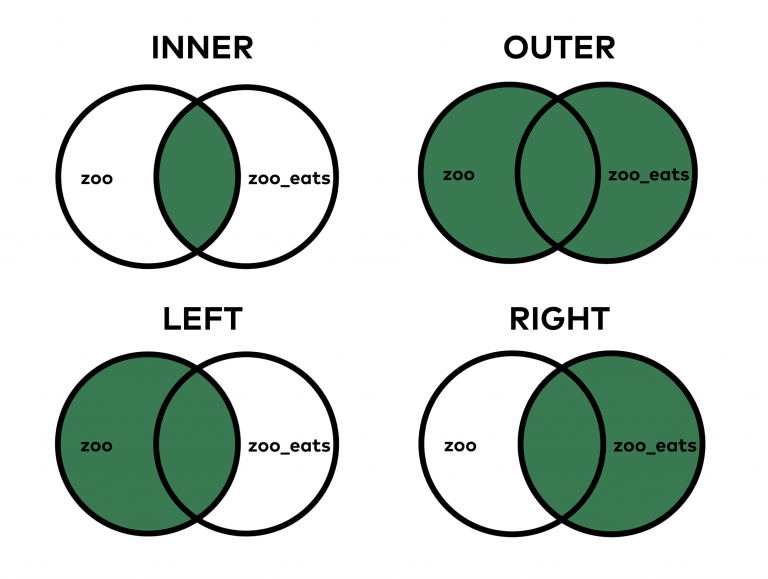

In [19]:
new_df = df_user_data.merge(df_feed_data, how = 'left', left_on='user_id', right_on='user_id')
new_df  # in this dataframe, the user id matches the user id from the df_feed_data table

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,action,target,ts
0,200,1,34,Russia,Degtyarsk,3,Android,ads,NaT,NaN,NaN,NaN,NaN
1,201,0,37,Russia,Abakan,0,Android,ads,NaT,NaN,NaN,NaN,NaN
2,202,1,17,Russia,Smolensk,4,Android,ads,NaT,NaN,NaN,NaN,NaN
3,203,0,18,Russia,Moscow,1,iOS,ads,NaT,NaN,NaN,NaN,NaN
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,Russia,Kaliningrad,4,Android,organic,NaT,NaN,NaN,NaN,NaN
168185,168549,0,18,Russia,Tula,2,Android,organic,NaT,NaN,NaN,NaN,NaN
168186,168550,1,41,Russia,Yekaterinburg,4,Android,organic,NaT,NaN,NaN,NaN,NaN
168187,168551,0,38,Russia,Moscow,3,iOS,organic,NaT,NaN,NaN,NaN,NaN


In [20]:
new_df.loc[new_df['user_id'] == 52758] # let's check if this is true

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,action,target,ts
50787,52758,1,19,Russia,Novosibirsk,1,Android,ads,NaT,NaN,NaN,NaN,NaN


### We will also connect the table `new_df` and `df_post_text` by `post_id` in order to add ONLY the column `topic` because how to process the column `text' is not obvious to me

In [21]:
df_post_text = df_post_text.drop("text", axis=1) # removing the text column
df_post_text.head(20)

,post_id,topic
0,1,business
1,2,business
2,3,business
3,4,business
4,5,business
5,6,business
6,14,business
7,2366,covid
8,7,business
9,8,business


In [22]:
# we connect the table new_df and df_post_text by post_id
new_df = new_df.merge(df_post_text, how='left', left_on='post_id', right_on='post_id')  
new_df

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,action,target,ts,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,NaT,NaN,NaN,NaN,NaN,NaN
1,201,0,37,Russia,Abakan,0,Android,ads,NaT,NaN,NaN,NaN,NaN,NaN
2,202,1,17,Russia,Smolensk,4,Android,ads,NaT,NaN,NaN,NaN,NaN,NaN
3,203,0,18,Russia,Moscow,1,iOS,ads,NaT,NaN,NaN,NaN,NaN,NaN
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,Russia,Kaliningrad,4,Android,organic,NaT,NaN,NaN,NaN,NaN,NaN
168185,168549,0,18,Russia,Tula,2,Android,organic,NaT,NaN,NaN,NaN,NaN,NaN
168186,168550,1,41,Russia,Yekaterinburg,4,Android,organic,NaT,NaN,NaN,NaN,NaN,NaN
168187,168551,0,38,Russia,Moscow,3,iOS,organic,NaT,NaN,NaN,NaN,NaN,NaN


### Final check after all connections

In [23]:
new_df.loc[new_df['post_id'] == 10] # let's check if this is true

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,action,target,ts,topic
112086,114967,0,29,Kazakhstan,Balyqshy,0,Android,organic,2021-11-10 19:17:20,10.0,view,0.0,1.636572e+09,business


In [24]:
new_df.loc[new_df['user_id'] == 52758] # let's check if this is true

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,action,target,ts,topic
50787,52758,1,19,Russia,Novosibirsk,1,Android,ads,NaT,NaN,NaN,NaN,NaN,NaN


In [25]:
## Drop the timestamp column
new_df = new_df.drop('timestamp', axis=1)

In [26]:
new_df

,user_id,gender,age,country,city,exp_group,os,source,post_id,action,target,ts,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,NaN,NaN,NaN,NaN,NaN
1,201,0,37,Russia,Abakan,0,Android,ads,NaN,NaN,NaN,NaN,NaN
2,202,1,17,Russia,Smolensk,4,Android,ads,NaN,NaN,NaN,NaN,NaN
3,203,0,18,Russia,Moscow,1,iOS,ads,NaN,NaN,NaN,NaN,NaN
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,Russia,Kaliningrad,4,Android,organic,NaN,NaN,NaN,NaN,NaN
168185,168549,0,18,Russia,Tula,2,Android,organic,NaN,NaN,NaN,NaN,NaN
168186,168550,1,41,Russia,Yekaterinburg,4,Android,organic,NaN,NaN,NaN,NaN,NaN
168187,168551,0,38,Russia,Moscow,3,iOS,organic,NaN,NaN,NaN,NaN,NaN


In [27]:
new_df.dtypes

user_id        int64
gender         int64
age            int64
country       object
city          object
exp_group      int64
os            object
source        object
post_id      float64
action        object
target       float64
ts           float64
topic         object
dtype: object

### Fill in the gaps of the columns `post_id (real attribute), action (categorical attribute), target (real attribute), ts (real attribute), topic (categorical attribute)`

In [28]:
pass_var = new_df.isna().sum()
print(pass_var)

user_id           0
gender            0
age               0
country           0
city              0
exp_group         0
os                0
source            0
post_id      163189
action       163189
target       163189
ts           163189
topic        163189
dtype: int64


In [29]:
# categorical and real columns
object_cols = ['action', 'topic']
numeric_cols = ['post_id', 'target', 'ts']

# fill in NaN'ы
new_df[numeric_cols] = new_df[numeric_cols].fillna(new_df[numeric_cols].median())  # заполняем медианой вещественные признаки
new_df[object_cols] = new_df[object_cols].fillna(new_df[object_cols].mode().iloc[0]) # заполняем самым популярным значением кат-ые признаки 

# let's see if there are any gaps left
pass_var = new_df.isna().sum()
print(pass_var)

user_id      0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
post_id      0
action       0
target       0
ts           0
topic        0
dtype: int64


In [30]:
### Converting the post_id and target columns to int
new_df[['post_id', 'target', 'ts']] = new_df[['post_id', 'target', 'ts']].astype('int64')
new_df.dtypes

user_id       int64
gender        int64
age           int64
country      object
city         object
exp_group     int64
os           object
source       object
post_id       int64
action       object
target        int64
ts            int64
topic        object
dtype: object

## Got a combed dataframe: no gaps, combined with three tables

In [31]:
new_df

,user_id,gender,age,country,city,exp_group,os,source,post_id,action,target,ts,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,3205,view,0,1637358242,movie
1,201,0,37,Russia,Abakan,0,Android,ads,3205,view,0,1637358242,movie
2,202,1,17,Russia,Smolensk,4,Android,ads,3205,view,0,1637358242,movie
3,203,0,18,Russia,Moscow,1,iOS,ads,3205,view,0,1637358242,movie
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,3205,view,0,1637358242,movie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,Russia,Kaliningrad,4,Android,organic,3205,view,0,1637358242,movie
168185,168549,0,18,Russia,Tula,2,Android,organic,3205,view,0,1637358242,movie
168186,168550,1,41,Russia,Yekaterinburg,4,Android,organic,3205,view,0,1637358242,movie
168187,168551,0,38,Russia,Moscow,3,iOS,organic,3205,view,0,1637358242,movie


In [32]:
X = new_df.drop(columns=['target']) # dataframe
y = new_df['target'] # series

### Transformation of the new_df table

In [33]:
### a function that returns returns lists of cat-th, thing-th columns, lists and indexes
### features for ONE and MTE encoding, lists and indexes for real columns
def prep_to_trans(data):
    
    """
    This function takes a dataframe as input and returns lists from:
    0 index returns a list of categorical columns
    1 the index will return a list of real columns
    2 the index will return a list of encoded categorical features by ONE
    3 the index will return a list of encoded categorical features by MTE
    4 the index will return a list of OHI indexes
    5 the index will return a list of MTE indexes
    6 the index will return the indexes of the real columns
    """
    object_cols = list(data.select_dtypes(include='object').columns)
    numeric_cols = list(data.select_dtypes(exclude='object').columns)

    cols_for_ohe = [x for x in object_cols if data[x].nunique() < 5]  # condition for encoding by ОНЕ
    cols_for_mte = [x for x in object_cols if data[x].nunique() >= 5]  #  condition for encoding by MTE 

    ### let's save the indexes of these columns
    cols_for_ohe_idx = [list(data.columns).index(col) for col in cols_for_ohe]  # indexes OHE
    cols_for_mte_idx = [list(data.columns).index(col) for col in cols_for_mte]  # indexes MTE
    numeric_cols_idx = [list(data.columns).index(col) for col in numeric_cols]  # indexes of real columns
    
    return object_cols, numeric_cols, cols_for_ohe, cols_for_mte, cols_for_ohe_idx, cols_for_mte_idx, numeric_cols_idx

In [34]:
### let's see how many topics and their number
new_df["topic"].value_counts()

movie            165069
covid              1159
sport               647
politics            529
business            321
entertainment       250
tech                214
Name: topic, dtype: int64

In [35]:
new_df_trans = prep_to_trans(X)
new_df_trans[4]
new_df_trans[5]


[3, 4, 11]

In [36]:
X

,user_id,gender,age,country,city,exp_group,os,source,post_id,action,ts,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,3205,view,1637358242,movie
1,201,0,37,Russia,Abakan,0,Android,ads,3205,view,1637358242,movie
2,202,1,17,Russia,Smolensk,4,Android,ads,3205,view,1637358242,movie
3,203,0,18,Russia,Moscow,1,iOS,ads,3205,view,1637358242,movie
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,3205,view,1637358242,movie
...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,Russia,Kaliningrad,4,Android,organic,3205,view,1637358242,movie
168185,168549,0,18,Russia,Tula,2,Android,organic,3205,view,1637358242,movie
168186,168550,1,41,Russia,Yekaterinburg,4,Android,organic,3205,view,1637358242,movie
168187,168551,0,38,Russia,Moscow,3,iOS,organic,3205,view,1637358242,movie


In [37]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler


### Your code is here
# t_1 is our transformer, where the tuple was passed: name, class name, cat 
# will transform our data and a list of column indexes that need to be processed 
# everything else goes into MeanTargetEncoder
t_1 = [('OneHotEncoder', OneHotEncoder(), new_df_trans[4]),
    ('MeanTargetEncoder', TargetEncoder(), new_df_trans[5])]

### Next, we pass the sheet to the Column Transformer class, the cat will be a transformer
new_df_trans_transform = ColumnTransformer(transformers=t_1)


# Training transformers on data
new_df_trans_transform.fit(X, y)

### Transformed the data
X_ = new_df_trans_transform.transform(X)


/home/user/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/user/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/user/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/user/anaconda3/lib/python3.9/site-packages/categ

In [38]:
print(X_.shape)

(168189, 9)


In [39]:
X_ = pd.DataFrame(X_)  # converting the matrix to a dataframe
X = pd.concat([X, X_], axis=1)
X

,user_id,gender,age,country,city,exp_group,os,source,post_id,action,...,topic,0,1,2,3,4,5,6,7,8
0,200,1,34,Russia,Degtyarsk,3,Android,ads,3205,view,...,movie,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,1.255881e-11,0.000842
1,201,0,37,Russia,Abakan,0,Android,ads,3205,view,...,movie,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,0.000000e+00,0.000842
2,202,1,17,Russia,Smolensk,4,Android,ads,3205,view,...,movie,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,0.000000e+00,0.000842
3,203,0,18,Russia,Moscow,1,iOS,ads,3205,view,...,movie,0.0,1.0,1.0,0.0,1.0,0.0,0.002443,3.324321e-03,0.000842
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,3205,view,...,movie,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,0.000000e+00,0.000842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,Russia,Kaliningrad,4,Android,organic,3205,view,...,movie,1.0,0.0,0.0,1.0,1.0,0.0,0.002443,0.000000e+00,0.000842
168185,168549,0,18,Russia,Tula,2,Android,organic,3205,view,...,movie,1.0,0.0,0.0,1.0,1.0,0.0,0.002443,0.000000e+00,0.000842
168186,168550,1,41,Russia,Yekaterinburg,4,Android,organic,3205,view,...,movie,1.0,0.0,0.0,1.0,1.0,0.0,0.002443,1.487357e-03,0.000842
168187,168551,0,38,Russia,Moscow,3,iOS,organic,3205,view,...,movie,0.0,1.0,0.0,1.0,1.0,0.0,0.002443,3.324321e-03,0.000842


In [40]:
X = X.drop(['os', 'source', 'action', 'country', 'city', 'topic'], axis=1)
X

,user_id,gender,age,exp_group,post_id,ts,0,1,2,3,4,5,6,7,8
0,200,1,34,3,3205,1637358242,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,1.255881e-11,0.000842
1,201,0,37,0,3205,1637358242,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,0.000000e+00,0.000842
2,202,1,17,4,3205,1637358242,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,0.000000e+00,0.000842
3,203,0,18,1,3205,1637358242,0.0,1.0,1.0,0.0,1.0,0.0,0.002443,3.324321e-03,0.000842
4,204,0,36,3,3205,1637358242,1.0,0.0,1.0,0.0,1.0,0.0,0.002443,0.000000e+00,0.000842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,4,3205,1637358242,1.0,0.0,0.0,1.0,1.0,0.0,0.002443,0.000000e+00,0.000842
168185,168549,0,18,2,3205,1637358242,1.0,0.0,0.0,1.0,1.0,0.0,0.002443,0.000000e+00,0.000842
168186,168550,1,41,4,3205,1637358242,1.0,0.0,0.0,1.0,1.0,0.0,0.002443,1.487357e-03,0.000842
168187,168551,0,38,3,3205,1637358242,0.0,1.0,0.0,1.0,1.0,0.0,0.002443,3.324321e-03,0.000842


In [41]:
new_df = pd.concat([X, y], axis=1)

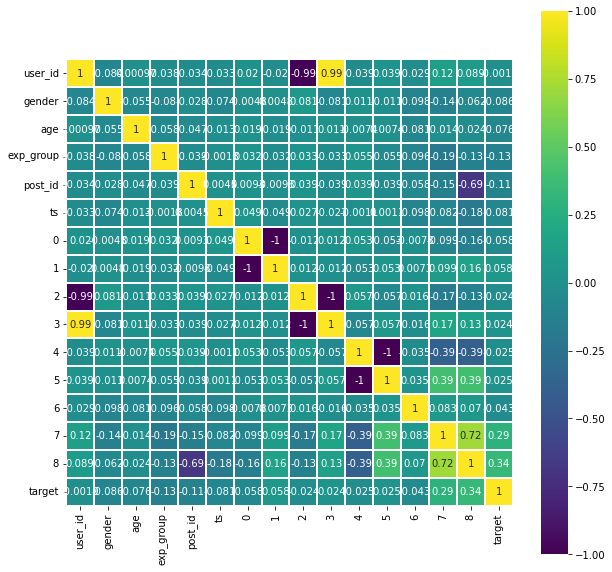

In [42]:
### Let's build a correlation matrix
data_corr = new_df.corr()

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(data_corr.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)
plt.show()

### There is a strong correlation in 0, 1, 2, 3, 4, 5, 7 columns

In [43]:
new_df = new_df.drop([0, 2, 4, 7], axis=1)
new_df

,user_id,gender,age,exp_group,post_id,ts,1,3,5,6,8,target
0,200,1,34,3,3205,1637358242,0.0,0.0,0.0,0.002443,0.000842,0
1,201,0,37,0,3205,1637358242,0.0,0.0,0.0,0.002443,0.000842,0
2,202,1,17,4,3205,1637358242,0.0,0.0,0.0,0.002443,0.000842,0
3,203,0,18,1,3205,1637358242,1.0,0.0,0.0,0.002443,0.000842,0
4,204,0,36,3,3205,1637358242,0.0,0.0,0.0,0.002443,0.000842,0
...,...,...,...,...,...,...,...,...,...,...,...,...
168184,168548,0,36,4,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842,0
168185,168549,0,18,2,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842,0
168186,168550,1,41,4,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842,0
168187,168551,0,38,3,3205,1637358242,1.0,1.0,0.0,0.002443,0.000842,0


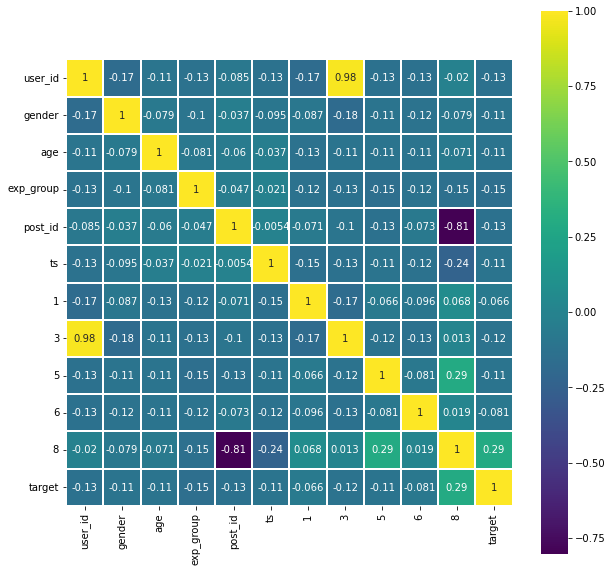

In [44]:
### Let's build a matrix after clearing correlations
data_corr = new_df.corr()

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(data_corr.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)
plt.show()


### Let's divide the dataframe into a test and a train

In [45]:
### Sort new_df by time from 1633195720 (Sat, October 02, 2021 17:28:40 GMT+0000) to 1640777194 (Wed, December 29, 2021 11:26:34 GMT+0000)

new_df = new_df.sort_values(by=['ts'])
new_df

,user_id,gender,age,exp_group,post_id,ts,1,3,5,6,8,target
48929,51864,1,16,0,6923,1633112862,1.0,0.0,0.0,0.002443,0.000842,0
48930,51864,1,16,0,4304,1633112939,1.0,0.0,0.0,0.002443,0.000842,0
48931,51864,1,16,0,1788,1633113058,1.0,0.0,0.0,0.002443,0.071097,0
48932,51864,1,16,0,1401,1633113226,1.0,0.0,0.0,0.002443,0.071097,0
48933,51864,1,16,0,2356,1633113239,1.0,0.0,0.0,0.002443,0.077653,0
...,...,...,...,...,...,...,...,...,...,...,...,...
111527,114965,1,51,4,1324,1640799564,0.0,1.0,0.0,0.002443,0.088847,0
111528,114965,1,51,4,981,1640799743,0.0,1.0,0.0,0.002443,0.088847,0
111529,114965,1,51,4,1454,1640799876,0.0,1.0,0.0,0.002443,0.071097,0
111530,114965,1,51,4,2707,1640799946,0.0,1.0,0.0,0.002443,0.077653,0


### Save the new dataframe

In [46]:
new_df.to_csv('new_df.csv', sep=';', index=False)


In [47]:
new_df

,user_id,gender,age,exp_group,post_id,ts,1,3,5,6,8,target
48929,51864,1,16,0,6923,1633112862,1.0,0.0,0.0,0.002443,0.000842,0
48930,51864,1,16,0,4304,1633112939,1.0,0.0,0.0,0.002443,0.000842,0
48931,51864,1,16,0,1788,1633113058,1.0,0.0,0.0,0.002443,0.071097,0
48932,51864,1,16,0,1401,1633113226,1.0,0.0,0.0,0.002443,0.071097,0
48933,51864,1,16,0,2356,1633113239,1.0,0.0,0.0,0.002443,0.077653,0
...,...,...,...,...,...,...,...,...,...,...,...,...
111527,114965,1,51,4,1324,1640799564,0.0,1.0,0.0,0.002443,0.088847,0
111528,114965,1,51,4,981,1640799743,0.0,1.0,0.0,0.002443,0.088847,0
111529,114965,1,51,4,1454,1640799876,0.0,1.0,0.0,0.002443,0.071097,0
111530,114965,1,51,4,2707,1640799946,0.0,1.0,0.0,0.002443,0.077653,0


### Let's keep X and y not divided into tren and test

In [48]:
X = new_df.drop('target', axis=1)
y = new_df['target']

X.to_csv('X.csv', sep=';', index=False)
y.to_csv('y.csv', sep=';', index=False)

### We will divide it into a train test

In [49]:
### We will divide it into a train test
train_new = new_df.iloc[:80000].copy()
test_new = new_df.iloc[80000:].copy()

### Divide into X,y train and test
X_train = train_new.drop('target', axis=1)
X_test = test_new.drop('target', axis=1)

y_train = train_new['target']
y_test = test_new['target']

In [50]:
y_test

137665    0
137663    0
137647    0
137648    0
137649    0
         ..
111527    0
111528    0
111529    0
111530    0
111531    0
Name: target, Length: 88189, dtype: int64

In [51]:
y_train

48929     0
48930     0
48931     0
48932     0
48933     0
         ..
137680    0
137681    0
137682    0
137675    0
137683    0
Name: target, Length: 80000, dtype: int64

In [52]:
X_train

,user_id,gender,age,exp_group,post_id,ts,1,3,5,6,8
48929,51864,1,16,0,6923,1633112862,1.0,0.0,0.0,0.002443,0.000842
48930,51864,1,16,0,4304,1633112939,1.0,0.0,0.0,0.002443,0.000842
48931,51864,1,16,0,1788,1633113058,1.0,0.0,0.0,0.002443,0.071097
48932,51864,1,16,0,1401,1633113226,1.0,0.0,0.0,0.002443,0.071097
48933,51864,1,16,0,2356,1633113239,1.0,0.0,0.0,0.002443,0.077653
...,...,...,...,...,...,...,...,...,...,...,...
137680,138026,0,20,4,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842
137681,138027,1,33,3,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842
137682,138028,1,30,1,3205,1637358242,1.0,1.0,0.0,0.000000,0.000842
137675,138021,1,44,4,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842


In [53]:
X_test

,user_id,gender,age,exp_group,post_id,ts,1,3,5,6,8
137665,138011,0,23,1,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842
137663,138009,1,32,1,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842
137647,137993,1,44,4,3205,1637358242,0.0,1.0,0.0,0.004651,0.000842
137648,137994,1,23,1,3205,1637358242,1.0,1.0,0.0,0.000000,0.000842
137649,137995,1,23,1,3205,1637358242,0.0,1.0,0.0,0.002443,0.000842
...,...,...,...,...,...,...,...,...,...,...,...
111527,114965,1,51,4,1324,1640799564,0.0,1.0,0.0,0.002443,0.088847
111528,114965,1,51,4,981,1640799743,0.0,1.0,0.0,0.002443,0.088847
111529,114965,1,51,4,1454,1640799876,0.0,1.0,0.0,0.002443,0.071097
111530,114965,1,51,4,2707,1640799946,0.0,1.0,0.0,0.002443,0.077653


### You can start learning! Let's start with CatBoostClassifier
#### We will measure ROC-AUC because in this task it is important for us to arrange as many objects correctly as possible in terms of probabilities.

In [54]:
params_1 = {'n_estimators': [1, 2, 5, 10, 30],
          'max_depth': [2, 3, 4, 5, 10, 15, 30]}

In [55]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

begin_time = datetime.datetime.now()

cboost = GridSearchCV(CatBoostClassifier(verbose=0, random_state=1), params_1)

cboost.fit(X_train, y_train)

print(f"Operating time of the CatBoostClassifier algorithm: {datetime.datetime.now() - begin_time}")

Operating time of the CatBoostClassifier algorithm: 0:00:51.674959


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 175.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/user/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/user/anaconda3/lib/python3.9/site-packages/catboost/core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/user/anaconda3/lib/python3.9/site-packages/catboo

In [56]:
print(f"Best parameter (CV score={cboost.best_score_:.3f}):")
print(cboost.best_params_)

print(f"The quality of the best model on the final test: {cboost.score(X_test, y_test).round(3)}")

Best parameter (CV score=0.977):
{'max_depth': 15, 'n_estimators': 1}
The quality of the best model on the final test: 0.998


The ROC-AUC of CatBoost on the train is equal to 0.866
The ROC-AUC of CatBoost on the test is equal to 0.706


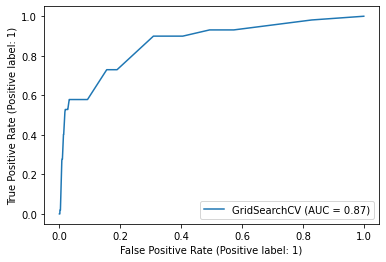

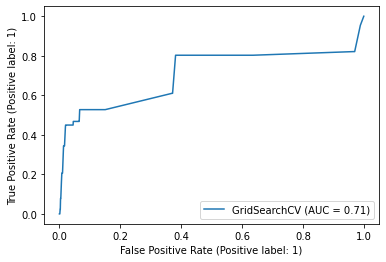

In [57]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

fpr_train_cboost, tpr_train_cboost, thresholds_train_cboost = roc_curve(y_train, cboost.predict_proba(X_train)[:, 1]) 
fpr_test_cboost, tpr_test_cboost, thresholds_test_cboost = roc_curve(y_test, cboost.predict_proba(X_test)[:, 1]) 


### На трейне
RocCurveDisplay.from_estimator(cboost, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of CatBoost on the train is equal to {round(auc(fpr_train_cboost, tpr_train_cboost),3)}")

### На тесте
RocCurveDisplay.from_estimator(cboost, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of CatBoost on the test is equal to {round(auc(fpr_test_cboost, tpr_test_cboost), 3)}")

### The model with the best parameters

In [58]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

cboost = CatBoostClassifier(max_depth=cboost.best_params_["max_depth"],
                                         n_estimators=cboost.best_params_["n_estimators"],random_state=1,
                                         verbose=0)


cboost.fit(X_train, y_train)

The ROC-AUC of CatBoost on the train is equal to 0.866
The ROC-AUC of CatBoost on the test is equal to 0.706


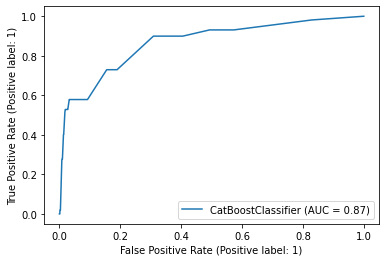

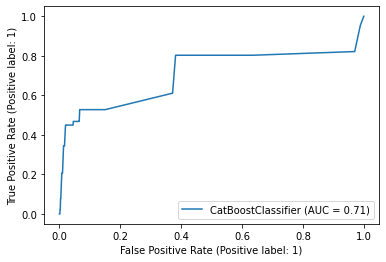

In [59]:
fpr_train_cboost, tpr_train_cboost, thresholds_train_cboost = roc_curve(y_train, cboost.predict_proba(X_train)[:, 1]) 
fpr_test_cboost, tpr_test_cboost, thresholds_test_cboost = roc_curve(y_test, cboost.predict_proba(X_test)[:, 1]) 

### On the train
RocCurveDisplay.from_estimator(cboost, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of CatBoost on the train is equal to {round(auc(fpr_train_cboost, tpr_train_cboost),3)}")

### On the test
RocCurveDisplay.from_estimator(cboost, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of CatBoost on the test is equal to {round(auc(fpr_test_cboost, tpr_test_cboost), 3)}")

In [60]:
y_pred_train = np.around(cboost.predict(X_train))  # predictions for the X-trainer
f1_score_train = np.array(f1_score(y_train, y_pred_train, average='weighted'))

y_pred_test = np.around(cboost.predict(X_test))  # predictions on the X-test
f1_score_test = np.array(f1_score(y_test, y_pred_test, average='weighted'))
print(f"Quality on the train: {f1_score_train.round(3)}")
print(f"Quality on the test: {f1_score_test.round(3)}")

Quality on the train: 0.997
Quality on the test: 0.996


### Let's try XGBoos

In [61]:
params_2 = {'n_estimators': [1, 2, 5, 10, 30],
          'max_depth': [2, 3, 4, 5, 10, 15, 30],
          'learning_rate': [0.1, 0.01, 0.001]}

In [62]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

begin_time = datetime.datetime.now()

grid = GridSearchCV(LGBMClassifier(), params_2)
grid.fit(X_train, y_train)
print(f"Operating time of the XGBoos algorithm: {datetime.datetime.now() - begin_time}")

[LightGBM] [Warning] Unknown parameter categorical_column=
Operating time of the XGBoos algorithm: 0:00:22.159155


In [63]:
print(f"Best parameter (CV score={grid.best_score_:.3f}):")
print(grid.best_params_)

print(f"The quality of the best model on the final test: {grid.score(X_test, y_test).round(3)}")

Best parameter (CV score=0.970):
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1}
The quality of the best model on the final test: 0.998


The ROC-AUC of XGBoos on the train is equal to 0.986
The ROC-AUC of XGBoos on the test is equal to 0.5


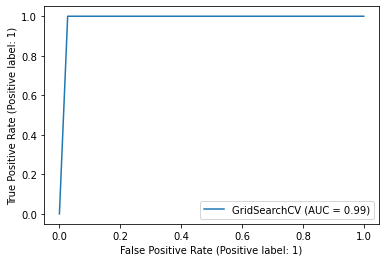

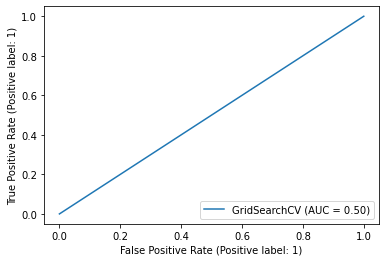

In [64]:
fpr_train_grid, tpr_train_grid, thresholds_train_grid = roc_curve(y_train, grid.predict_proba(X_train)[:, 1]) 
fpr_test_grid, tpr_test_grid, thresholds_test_grid = roc_curve(y_test, grid.predict_proba(X_test)[:, 1]) 


### On the train
RocCurveDisplay.from_estimator(grid, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of XGBoos on the train is equal to {round(auc(fpr_train_grid, tpr_train_grid),3)}")

### On the test
RocCurveDisplay.from_estimator(grid, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of XGBoos on the test is equal to {round(auc(fpr_test_grid, tpr_test_grid), 3)}")

In [65]:
y_pred_test_grid = np.around(grid.predict(X_test))  # predictions on the X-test
f1_score_test_grid = np.array(f1_score(y_test, y_pred_test_grid, average='weighted'))

y_pred_train_grid = np.around(grid.predict(X_train))  # predictions for the X-trainer
f1_score_train_grid = np.array(f1_score(y_train, y_pred_train_grid, average='weighted'))

print(f"The quality of XGBoos on the train: {f1_score_train_grid.round(3)}")
print(f"The quality of XGBoos on the test: {f1_score_test_grid.round(3)}")


The quality of XGBoos on the train: 0.997
The quality of XGBoos on the test: 0.996


### "Random forest" models

In [66]:
param_grid = {
    "random_forest__max_depth": [1, 2, 3, 4, 5, 10, 15, 20],
    "random_forest__n_estimators":[2, 3, 4, 5, 10, 15, 30]
}

In [67]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


### Created a "Random Forest" model
random_forest_pipe = Pipeline([("random_forest", 
                               RandomForestClassifier(verbose=1, random_state=1))])

search_random_forest = GridSearchCV(random_forest_pipe, 
                      param_grid, 
                      scoring='roc_auc')

search_random_forest.fit(X_train, y_train)

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. 

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names

GridSearchCV(estimator=Pipeline(steps=[('random_forest',
                                        RandomForestClassifier(random_state=1,
                                                               verbose=1))]),
             param_grid={'random_forest__max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                         'random_forest__n_estimators': [2, 3, 4, 5, 10, 15,
                                                         30]},
             scoring='roc_auc')

In [68]:
print(f"Best parameter (CV score={search_random_forest.best_score_:.3f}):")
print(search_random_forest.best_params_)

print(f"The quality of the best model on the final ROC-AUC test: {search_random_forest.score(X_test, y_test)}")

Best parameter (CV score=0.989):
{'random_forest__max_depth': 2, 'random_forest__n_estimators': 15}
The quality of the best model on the final ROC-AUC test: 0.7375648397058288


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


### The model itself with the best parameters

In [69]:
search_random_forest.best_params_

{'random_forest__max_depth': 2, 'random_forest__n_estimators': 15}

In [70]:
roc_auc_train_for_forest  = []
roc_auc_test_for_forest = []

begin_time = datetime.datetime.now()
model_random_forest = RandomForestClassifier(n_estimators=search_random_forest.best_params_['random_forest__n_estimators'],
                                   max_depth=search_random_forest.best_params_['random_forest__max_depth'],
                                   random_state=1)
model_random_forest.fit(X_train, y_train)

print(f"Algorithm running time: {datetime.datetime.now() - begin_time}")

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Algorithm running time: 0:00:00.194202


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


The ROC-AUC of a random forest on the train is equal to 0.988
The ROC-AUC of a random forest on the test is equal to 0.738


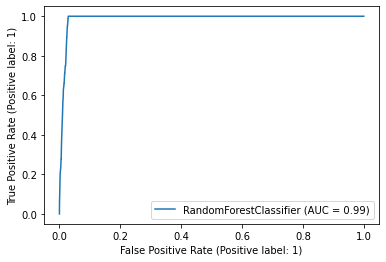

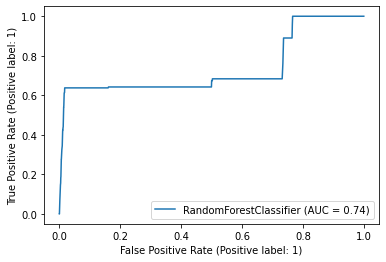

In [71]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model_random_forest.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_random_forest.predict_proba(X_test)[:, 1]) 
### On the train
roc_auc_train_for_forest.append(round(auc(fpr_train, tpr_train), 3))

### On the test
roc_auc_test_for_forest.append(round(auc(fpr_test, tpr_test), 3))
RocCurveDisplay.from_estimator(model_random_forest, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of a random forest on the train is equal to {max(roc_auc_train_for_forest)}")

### On the test
RocCurveDisplay.from_estimator(model_random_forest, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of a random forest on the test is equal to {max(roc_auc_test_for_forest)}")

### Gradient boosting

In [72]:
param_grid_2 = {
    "gradientboosting__max_depth": [1, 2, 3, 4],
    "gradientboosting__n_estimators":[2, 3, 4, 5, 10, 15, 30]
}

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
### Created a gradient boosting model
gradient_boosting = Pipeline([("gradientboosting", 
                               GradientBoostingClassifier(verbose=1, random_state=1))])

search_gradient_boosting = GridSearchCV(gradient_boosting, 
                      param_grid_2, 
                      scoring='roc_auc')

search_gradient_boosting.fit(X_train, y_train)

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

      Iter       Train Loss   Remaining Time 
         1           0.0036            0.02s
         2           0.0033            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.02s
         2           0.0194            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.02s
         2           0.0194            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.02s
         2           0.0195            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.02s
         2           0.0184            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.05s
         2           0.0033            0.03s
         3           0.0030            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

      Iter       Train Loss   Remaining Time 
         1           0.0200            0.05s
         2           0.0194            0.03s
         3           0.0190            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.05s
         2           0.0194            0.02s
         3           0.0190            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

         1           0.0200            0.05s
         2           0.0195            0.02s
         3           0.0191            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.04s
         2           0.0184            0.02s
         3           0.0180            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.06s
         2           0.0033            0.04s
         3           0.0030            0.02s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

         4           0.0027            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.06s
         2           0.0194            0.04s
         3           0.0190            0.02s
         4           0.0188            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.06s
         2           0.0194            0.04s
         3           0.0190            0.02s
         4           0.0188            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

      Iter       Train Loss   Remaining Time 
         1           0.0200            0.06s
         2           0.0195            0.04s
         3           0.0191            0.02s
         4           0.0187            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.06s
         2           0.0184            0.04s
         3           0.0180            0.02s
         4           0.0177            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0036            0.09s
         2           0.0033            0.07s
         3           0.0030            0.04s
         4           0.0027            0.02s
         5           0.0024            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.08s
         2           0.0194            0.06s
         3           0.0190            0.04s
         4           0.0188            0.02s
         5           0.0186            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.09s
         2           0.0194            0.07s
         3           0.0190            0.04s
         4           0.0188            0.02s
         5           0.0185            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.09s
         2           0.0195            0.06s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0191            0.04s
         4           0.0187            0.02s
         5           0.0184            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.08s
         2           0.0184            0.06s
         3           0.0180            0.04s
         4           0.0177            0.02s
         5           0.0175            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.18s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0033            0.17s
         3           0.0030            0.14s
         4           0.0027            0.12s
         5           0.0024            0.10s
         6           0.0022            0.08s
         7           0.0020            0.06s
         8           0.0018            0.04s
         9           0.0016            0.02s
        10           0.0015            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.17s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0194            0.17s
         3           0.0190            0.14s
         4           0.0188            0.12s
         5           0.0186            0.10s
         6           0.0182            0.08s
         7           0.0179            0.06s
         8           0.0178            0.04s
         9           0.0177            0.02s
        10           0.0174            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0200            0.19s
         2           0.0194            0.17s
         3           0.0190            0.14s
         4           0.0188            0.12s
         5           0.0185            0.10s
         6           0.0182            0.08s
         7           0.0179            0.06s
         8           0.0178            0.04s
         9           0.0175            0.02s
        10           0.0174            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0200            0.20s
         2           0.0195            0.18s
         3           0.0191            0.15s
         4           0.0187            0.13s
         5           0.0184            0.10s
         6           0.0183            0.08s
         7           0.0179            0.06s
         8           0.0178            0.04s
         9           0.0176            0.02s
        10           0.0174            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0185            0.19s
         2           0.0184            0.17s
         3           0.0180            0.14s
         4           0.0177            0.12s
         5           0.0175            0.10s
         6           0.0172            0.08s
         7           0.0171            0.06s
         8           0.0168            0.04s
         9           0.0166            0.02s
        10           0.0166            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0036            0.30s
         2           0.0033            0.30s
         3           0.0030            0.25s
         4           0.0027            0.23s
         5           0.0024            0.20s
         6           0.0022            0.18s
         7           0.0020            0.16s
         8           0.0018            0.14s
         9           0.0016            0.12s
        10           0.0015            0.10s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0200            0.27s
         2           0.0194            0.25s
         3           0.0190            0.22s
         4           0.0188            0.21s
         5           0.0186            0.19s
         6           0.0182            0.17s
         7           0.0179            0.15s
         8           0.0178            0.13s
         9           0.0177            0.12s
        10           0.0174            0.10s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0200            0.27s
         2           0.0194            0.25s
         3           0.0190            0.22s
         4           0.0188            0.21s
         5           0.0185            0.19s
         6           0.0182            0.17s
         7           0.0179            0.15s
         8           0.0178            0.13s
         9           0.0175            0.11s
        10           0.0174            0.09s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0200            0.29s
         2           0.0195            0.27s
         3           0.0191            0.23s
         4           0.0187            0.21s
         5           0.0184            0.20s
         6           0.0183            0.18s
         7           0.0179            0.16s
         8           0.0178            0.14s
         9           0.0176            0.12s
        10           0.0174            0.10s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0185            0.29s
         2           0.0184            0.27s
         3           0.0180            0.24s
         4           0.0177            0.22s
         5           0.0175            0.20s
         6           0.0172            0.18s
         7           0.0171            0.16s
         8           0.0168            0.14s
         9           0.0166            0.12s
        10           0.0166            0.10s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0036            0.56s
         2           0.0033            0.54s
         3           0.0030            0.49s
         4           0.0027            0.48s
         5           0.0024            0.46s
         6           0.0022            0.45s
         7           0.0020            0.43s
         8           0.0018            0.42s
         9           0.0016            0.40s
        10           0.0015            0.38s
        20           0.0005            0.20s
        30           0.0002            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0200            0.66s
         2           0.0194            0.62s
         3           0.0190            0.55s
         4           0.0188            0.52s
         5           0.0186            0.50s
         6           0.0182            0.48s
         7           0.0179            0.46s
         8           0.0178            0.44s
        

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


        10           0.0174            0.39s
        20           0.0164            0.20s
        30           0.0159            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0200            0.60s
         2           0.0194            0.57s
         3           0.0190            0.53s
         4           0.0188            0.50s
         5           0.0185            0.48s
         6           0.0182            0.47s
         7           0.0179            0.45s
         8           0.0178            0.43s
         9           0.0175            0.41s
        10           0.0174            0.39s
        20           0.0164            0.20s
        30           0.0159            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0200            0.59s
         2           0.0195            0.57s
         3           0.0191            0.53s
         4           0.0187            0.52s
         5           0.0184            0.51s
         6           0.0183            0.48s
         7           0.0179            0.46s
         8           0.0178            0.44s
         9           0.0176            0.42s
        10           0.0174            0.40s
        20           0.0164            0.21s
        30           0.0159            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0185            0.66s
         2           0.0184            0.62s
         3           0.0180            0.55s
         4           0.0177            0.52s
         5           0.0175            0.50s
         6           0.0172            0.48s
         7           0.0171            0.47s
         8           0.0168            0.45s
         9           0.0166            0.42s
        10           0.0166            0.40s
        20           0.0156            0.21s
        30           0.0151            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

      Iter       Train Loss   Remaining Time 
         1           0.0036            0.03s
         2           0.0033            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.02s
         2           0.0210            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.02s
         2           0.0210            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

      Iter       Train Loss   Remaining Time 
         1           0.0221            0.02s
         2           0.0212            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.02s
         2           0.0179            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.06s
         2           0.0033            0.03s
         3           0.0030            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.04s
         2           0.0210            0.03s
         3           0.0204            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.04s
         2           0.0210            0.03s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0202            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.05s
         2           0.0212            0.03s
         3           0.0203            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.04s
         2           0.0179            0.03s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0175            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.10s
         2           0.0033            0.05s
         3           0.0030            0.02s
         4           0.0027            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.06s
         2           0.0210            0.06s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0204            0.03s
         4           0.0197            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.06s
         2           0.0210            0.05s
         3           0.0202            0.03s
         4           0.0195            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.06s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0212            0.05s
         3           0.0203            0.03s
         4           0.0196            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.06s
         2           0.0179            0.05s
         3           0.0175            0.03s
         4           0.0173            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0036            0.13s
         2           0.0033            0.08s
         3           0.0030            0.05s
         4           0.0027            0.02s
         5           0.0024            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.08s
         2           0.0210            0.08s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0204            0.05s
         4           0.0197            0.03s
         5           0.0191            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.08s
         2           0.0210            0.08s
         3           0.0202            0.06s
         4           0.0195            0.03s
         5           0.0190            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.08s
         2           0.0212            0.08s
         3           0.0203            0.05s
         4           0.0196            0.03s
         5           0.0192            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0185            0.08s
         2           0.0179            0.08s
         3           0.0175            0.06s
         4           0.0173            0.03s
         5           0.0170            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.28s
         2           0.0033            0.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0030            0.17s
         4           0.0027            0.14s
         5           0.0024            0.11s
         6           0.0022            0.09s
         7           0.0020            0.07s
         8           0.0018            0.04s
         9           0.0016            0.02s
        10           0.0015            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.20s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0210            0.22s
         3           0.0204            0.20s
         4           0.0197            0.18s
         5           0.0191            0.15s
         6           0.0188            0.12s
         7           0.0183            0.09s
         8           0.0179            0.06s
         9           0.0175            0.03s
        10           0.0174            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.18s
         2           0.0210            0.21s
         3           0.0202            0.19s
         4           0.0195            0.17s
         5           0.0190            0.14s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         6           0.0185            0.12s
         7           0.0182            0.09s
         8           0.0178            0.06s
         9           0.0175            0.03s
        10           0.0172            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.18s
         2           0.0212            0.21s

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(



         3           0.0203            0.19s
         4           0.0196            0.18s
         5           0.0192            0.15s
         6           0.0187            0.12s
         7           0.0183            0.09s
         8           0.0179            0.06s
         9           0.0177            0.03s
        10           0.0174            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.20s
         2           0.0179            0.21s
         3           0.0175            0.20s
         4           0.0173            0.17s
         5           0.0170            0.15s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         6           0.0168            0.12s
         7           0.0165            0.09s
         8           0.0163            0.06s
         9           0.0160            0.03s
        10           0.0159            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.44s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0033            0.34s
         3           0.0030            0.27s
         4           0.0027            0.25s
         5           0.0024            0.22s
         6           0.0022            0.19s
         7           0.0020            0.17s
         8           0.0018            0.15s
         9           0.0016            0.13s
        10           0.0015            0.10s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0221            0.30s
         2           0.0210            0.34s
         3           0.0204            0.34s
         4           0.0197            0.32s
         5           0.0191            0.30s
         6           0.0188            0.27s
         7           0.0183            0.25s
         8           0.0179            0.22s
         9           0.0175            0.19s
        10           0.0174            0.16s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0221            0.28s
         2           0.0210            0.33s
         3           0.0202            0.33s
         4           0.0195            0.31s
         5           0.0190            0.29s
         6           0.0185            0.27s
         7           0.0182            0.24s
         8           0.0178            0.21s
         9           0.0175            0.19s
        10           0.0172            0.15s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0221            0.30s
         2           0.0212            0.34s
         3           0.0203            0.34s
         4           0.0196            0.32s
         5           0.0192            0.30s
         6           0.0187            0.27s
         7           0.0183            0.25s
         8           0.0179            0.22s
         9           0.0177            0.19s
        10           0.0174            0.16s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0185            0.30s
         2           0.0179            0.34s
         3           0.0175            0.33s
         4           0.0173            0.32s
         5           0.0170            0.29s
         6           0.0168            0.27s
         7           0.0165            0.25s
         8           0.0163            0.22s
         9           0.0160            0.19s
        10           0.0159            0.16s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0036            0.91s
         2           0.0033            0.73s
         3           0.0030            0.62s
         4           0.0027            0.58s
         5           0.0024            0.54s
         6           0.0022            0.51s
         7           0.0020            0.48s
         8           0.0018            0.46s
         9           0.0016            0.44s
        10           0.0015            0.41s
        20           0.0005            0.21s
        30           0.0002            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.62s
         2           0.0210            0.78s
         3           0.0204            0.78s
         4           0.0197            0.76s
         5           0.0191            0.75s
         6           0.0188            0.74s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         7           0.0183            0.72s
         8           0.0179            0.70s
         9           0.0175            0.67s
        10           0.0174            0.64s
        20           0.0161            0.33s
        30           0.0152            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.57s
         2           0.0210            0.73s
         3           0.0202            0.75s
         4           0.0195            0.74s
         5           0.0190            0.72s
         6           0.0185            0.71s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         7           0.0182            0.70s
         8           0.0178            0.69s
         9           0.0175            0.66s
        10           0.0172            0.63s
        20           0.0163            0.32s
        30           0.0156            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.57s
         2           0.0212            0.71s
         3           0.0203            0.72s
         4           0.0196            0.72s
         5           0.0192            0.71s
         6           0.0187            0.71s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         7           0.0183            0.69s
         8           0.0179            0.68s
         9           0.0177            0.65s
        10           0.0174            0.63s
        20           0.0160            0.32s
        30           0.0155            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0185            0.57s
         2           0.0179            0.73s
         3           0.0175            0.73s
         4           0.0173            0.73s
         5           0.0170            0.72s
         6           0.0168            0.70s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         7           0.0165            0.69s
         8           0.0163            0.68s
         9           0.0160            0.65s
        10           0.0159            0.62s
        20           0.0148            0.32s
        30           0.0142            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.03s
         2           0.0033            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0216            0.02s
         2         414.5128            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0224            0.02s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

         2         414.5134            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0226            0.02s
         2         414.5138            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0207            0.02s
         2           0.0197            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

         1           0.0036            0.07s
         2           0.0033            0.03s
         3           0.0030            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0216            0.04s
         2         414.5128            0.03s
         3        1854.1345            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0224            0.04s
         2         414.5134            0.04s
         3        1854.1349            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0226            0.04s
         2         414.5138            0.03s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3        1854.1354            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0207            0.04s
         2           0.0197            0.03s
         3           0.0189            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.10s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0033            0.05s
         3           0.0030            0.02s
         4           0.0027            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0216            0.07s
         2         414.5128            0.07s
         3        1854.1345            0.04s
         4        1854.1340            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0224            0.08s
         2         414.5134            0.07s
         3        1854.1349            0.04s
         4        1854.1344            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0226            0.07s
         2         414.5138            0.07s
         3        1854.1354            0.04s
         4        1854.1349            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0207            0.07s
         2           0.0197            0.07s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0189            0.04s
         4           0.0183            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.13s
         2           0.0033            0.08s
         3           0.0030            0.05s
         4           0.0027            0.02s
         5           0.0024            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0216            0.09s
         2         414.5128            0.10s
         3        1854.1345            0.07s
         4        1854.1340            0.04s
         5        1854.1335            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0224            0.09s
         2         414.5134            0.11s
         3        1854.1349            0.08s
         4        1854.1344            0.04s
         5        1854.1341            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0226            0.10s
         2         414.5138            0.11s
         3        1854.1354            0.08s
         4        1854.1349            0.04s
         5        1854.1345            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0207            0.09s
         2           0.0197            0.10s
         3           0.0189            0.07s
         4           0.0183            0.04s
         5           0.0177            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.31s
         2           0.0033            0.22s
         3           0.0030            0.17s
         4           0.0027            0.14s
         5           0.0024            0.11s
         6           0.0022            0.09s
         7           0.0020            0.06s
         8           0.0018            0.04s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         9           0.0016            0.02s
        10           0.0015            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0216            0.20s
         2         414.5128            0.27s
         3        1854.1345            0.26s
         4        1854.1340            0.23s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5        1854.1335            0.20s
         6        1854.1331            0.17s
         7        1854.1328            0.13s
         8        1854.1327            0.09s
         9        1854.1324            0.04s
        10        1854.1321            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0224            0.14s
         2         414.5134            0.25s
         3        1854.1349            0.24s
         4        1854.1344            0.23s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5        1854.1341            0.19s
         6        1854.1337            0.16s
         7        1854.1334            0.13s
         8        1854.1330            0.08s
         9        1854.1329            0.04s
        10        1854.1327            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0226            0.19s
         2         414.5138            0.27s
         3        1854.1354            0.25s
         4        1854.1349            0.23s
         5        1854.1345            0.20s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         6        1854.1341            0.16s
         7        1854.1337            0.13s
         8        1854.1334            0.08s
         9        1854.1333            0.04s
        10        1854.1330            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0207            0.20s
         2           0.0197            0.28s
         3           0.0189            0.26s
         4           0.0183            0.24s
         5           0.0177            0.20s
         6           0.0174            0.17s
         7           0.0169            0.13s
         8           0.0167            0.09s
         9           0.0164            0.04s
        10           0.0161            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0036            0.46s
         2           0.0033            0.36s
         3           0.0030            0.30s
         4           0.0027            0.26s
         5           0.0024            0.23s
         6           0.0022            0.20s
         7           0.0020            0.18s
         8           0.0018            0.15s
         9           0.0016            0.13s
        10           0.0015            0.11s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0216            0.28s
         2         414.5128            0.43s
         3        1854.1345            0.44s
         4        1854.1340            0.42s
         5        1854.1335            0.39s
         6        1854.1331            0.37s
         7        1854.1328            0.34s
         8        1854.1327            0.30s
         9        1854.1324            0.26s
        10        1854.1321            0.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0224            0.29s
         2         414.5134            0.43s
         3        1854.1349            0.43s
         4        1854.1344            0.42s
         5        1854.1341            0.40s
         6        1854.1337            0.37s
         7        1854.1334            0.33s
         8        1854.1330            0.30s
         9        1854.1329            0.25s
        10        1854.1327            0.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0226            0.29s
         2         414.5138            0.43s
         3        1854.1354            0.43s
         4        1854.1349            0.42s
         5        1854.1345            0.39s
         6        1854.1341            0.36s
         7        1854.1337            0.33s
         8        1854.1334            0.29s
         9        1854.1333            0.25s
        10        1854.1330            0.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0207            0.28s
         2           0.0197            0.41s
         3           0.0189            0.42s
         4           0.0183            0.41s
         5           0.0177            0.39s
         6           0.0174            0.36s
         7           0.0169            0.33s
         8           0.0167            0.29s
         9           0.0164            0.25s
        10           0.0161            0.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0036            0.92s
         2           0.0033            0.74s
         3           0.0030            0.62s
         4           0.0027            0.57s
         5           0.0024            0.54s
         6           0.0022            0.51s
         7           0.0020            0.49s
         8           0.0018            0.46s
         9           0.0016            0.44s
        10           0.0015            0.41s
        20           0.0005            0.21s
        30           0.0002            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0216            0.62s
         2         414.5128            0.96s
         3        1854.1345            1.01s
         4        1854.1340            1.02s
         5        1854.1335            1.00s
         6        1854.1331            0.99s
         7        1854.1328            0.97s
         8        1854.1327            0.93s
         9        1854.1324            0.89s
        10        1854.1321            0.85s
        20        1854.1308            0.44s
        30        1854.1298            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0224            0.61s
         2         414.5134            0.92s
         3        1854.1349            0.96s
         4        1854.1344            0.98s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5        1854.1341            0.97s
         6        1854.1337            0.97s
         7        1854.1334            0.95s
         8        1854.1330            0.92s
         9        1854.1329            0.88s
        10        1854.1327            0.84s
        20        1854.1312            0.44s
        30        1854.1303            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0226            0.63s
         2         414.5138            0.92s
         3        1854.1354            0.98s
         4        1854.1349            1.01s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5        1854.1345            0.99s
         6        1854.1341            1.00s
         7        1854.1337            0.97s
         8        1854.1334            0.94s
         9        1854.1333            0.90s
        10        1854.1330            0.86s
        20        1854.1317            0.45s
        30        1854.1305            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0207            0.59s
         2           0.0197            0.89s
         3           0.0189            0.95s
         4           0.0183            0.99s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5           0.0177            0.99s
         6           0.0174            1.00s
         7           0.0169            0.97s
         8           0.0167            0.94s
         9           0.0164            0.90s
        10           0.0161            0.86s
        20           0.0146            0.45s
        30           0.0138            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.03s
         2           0.0033            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.02s
         2           0.0432            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

         1           0.0213            0.02s
         2           0.0191            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0234            0.02s
         2           0.0201            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0210            0.02s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/hom

         2           0.0174            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.07s
         2           0.0033            0.03s
         3           0.0030            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.04s
         2           0.0432            0.04s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0426            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0213            0.05s
         2           0.0191            0.04s
         3           0.0183            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0234            0.04s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0201            0.04s
         3           0.0195            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0210            0.04s
         2           0.0174            0.04s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0169            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.10s
         2           0.0033            0.05s
         3           0.0030            0.02s
         4           0.0027            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.06s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0432            0.08s
         3           0.0426            0.05s
         4           0.0420            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0213            0.07s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0191            0.08s
         3           0.0183            0.05s
         4           0.0177            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0234            0.07s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0201            0.08s
         3           0.0195            0.05s
         4           0.0189            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0210            0.07s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0174            0.08s
         3           0.0169            0.05s
         4           0.0165            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.14s
         2           0.0033            0.08s
         3           0.0030            0.05s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         4           0.0027            0.02s
         5           0.0024            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.09s
         2           0.0432            0.12s
         3           0.0426            0.09s
         4           0.0420            0.05s
         5           0.0415            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0213            0.08s
         2           0.0191            0.12s
         3           0.0183            0.09s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         4           0.0177            0.05s
         5           0.0171            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0234            0.09s
         2           0.0201            0.12s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0195            0.09s
         4           0.0189            0.05s
         5           0.0182            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0210            0.08s
         2           0.0174            0.12s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0169            0.09s
         4           0.0165            0.05s
         5           0.0163            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.30s
         2           0.0033            0.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0030            0.16s
         4           0.0027            0.14s
         5           0.0024            0.11s
         6           0.0022            0.09s
         7           0.0020            0.07s
         8           0.0018            0.04s
         9           0.0016            0.02s
        10           0.0015            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.20s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0432            0.34s
         3           0.0426            0.32s
         4           0.0420            0.29s
         5           0.0415            0.26s
         6           0.0410            0.21s
         7           0.0406            0.16s
         8           0.0403            0.11s
         9           0.0400            0.05s
        10           0.0398            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0213            0.19s
         2           0.0191            0.32s
         3           0.0183            0.31s
         4           0.0177            0.28s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5           0.0171            0.25s
         6           0.0167            0.21s
         7           0.0162            0.16s
         8           0.0159            0.11s
         9           0.0155            0.05s
        10           0.0152            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0234            0.19s
         2           0.0201            0.31s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         3           0.0195            0.31s
         4           0.0189            0.29s
         5           0.0182            0.26s
         6           0.0176            0.21s
         7           0.0171            0.16s
         8           0.0167            0.11s
         9           0.0164            0.05s
        10           0.0161            0.00s
      Iter       Train Loss   Remaining Time 


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         1           0.0210            0.19s
         2           0.0174            0.32s
         3           0.0169            0.32s
         4           0.0165            0.29s
         5           0.0163            0.26s
         6           0.0159            0.21s
         7           0.0155            0.16s
         8           0.0154            0.11s
         9           0.0151            0.06s
        10           0.0149            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0036            0.44s
         2           0.0033            0.34s
         3           0.0030            0.28s
         4           0.0027            0.25s
         5           0.0024            0.22s
         6           0.0022            0.19s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         7           0.0020            0.17s
         8           0.0018            0.15s
         9           0.0016            0.13s
        10           0.0015            0.10s
      Iter       Train Loss   Remaining Time 
         1           0.0221            0.30s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         2           0.0432            0.51s
         3           0.0426            0.55s
         4           0.0420            0.54s
         5           0.0415            0.51s
         6           0.0410            0.47s
         7           0.0406            0.43s
         8           0.0403            0.38s
         9           0.0400            0.33s
        10           0.0398            0.27s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0213            0.29s
         2           0.0191            0.51s
         3           0.0183            0.53s
         4           0.0177            0.52s
         5           0.0171            0.51s
         6           0.0167            0.47s
         7           0.0162            0.42s
         8           0.0159            0.37s
         9           0.0155            0.32s
        10           0.0152            0.27s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0234            0.32s
         2           0.0201            0.52s
         3           0.0195            0.54s
         4           0.0189            0.53s
         5           0.0182            0.51s
         6           0.0176            0.47s
         7           0.0171            0.43s
         8           0.0167            0.38s
         9           0.0164            0.32s
        10           0.0161            0.27s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0210            0.29s
         2           0.0174            0.51s
         3           0.0169            0.53s
         4           0.0165            0.52s
         5           0.0163            0.51s
         6           0.0159            0.47s
         7           0.0155            0.42s
         8           0.0154            0.37s
         9           0.0151            0.32s
        10           0.0149            0.27s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0036            0.93s
         2           0.0033            0.74s
         3           0.0030            0.63s
         4           0.0027            0.60s
         5           0.0024            0.56s
         6           0.0022            0.53s
         7           0.0020            0.50s
         8           0.0018            0.47s
         9           0.0016            0.44s
        10           0.0015            0.41s
        20           0.0005            0.21s
        30           0.0002            0.00s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           0.0221            0.65s
         2           0.0432            1.12s
         3           0.0426            1.20s
         4           0.0420            1.23s
         5           0.0415            1.26s
         6           0.0410            1.25s
         7           0.0406            1.22s
         8           0.0403            1.19s
         9           0.0400            1.16s
        10           0.0398            1.11s
        20           0.0381            0.57s
        30           3.6555            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0213            0.62s
         2           0.0191            1.12s
         3           0.0183            1.21s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         4           0.0177            1.26s
         5           0.0171            1.27s
         6           0.0167            1.25s
         7           0.0162            1.21s
         8           0.0159            1.18s
         9           0.0155            1.13s
        10           0.0152            1.08s
        20           0.0133            0.57s
        30           0.0122            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0234            0.61s
         2           0.0201            1.09s
         3           0.0195            1.19s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         4           0.0189            1.25s
         5           0.0182            1.27s
         6           0.0176            1.25s
         7           0.0171            1.22s
         8           0.0167            1.18s
         9           0.0164            1.14s
        10           0.0161            1.09s
        20           0.0142            0.57s
        30           0.0130            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0210            0.62s
         2           0.0174            1.11s
         3           0.0169            1.21s
         4           0.0165            1.26s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         5           0.0163            1.31s
         6           0.0159            1.28s
         7           0.0155            1.24s
         8           0.0154            1.19s
         9           0.0151            1.15s
        10           0.0149            1.10s
        20           0.0133            0.57s
        30           0.0116            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0194            0.76s
         2           0.0186            1.37s
         3           0.0180            1.50s


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


         4           0.0175            1.60s
         5           0.0170            1.61s
         6           0.0166            1.58s
         7           0.0162            1.54s
         8           0.0159            1.49s
         9           0.0156            1.43s
        10           0.0154            1.36s
        20           0.0137            0.71s
        30           0.0130            0.00s


GridSearchCV(estimator=Pipeline(steps=[('gradientboosting',
                                        GradientBoostingClassifier(random_state=1,
                                                                   verbose=1))]),
             param_grid={'gradientboosting__max_depth': [1, 2, 3, 4],
                         'gradientboosting__n_estimators': [2, 3, 4, 5, 10, 15,
                                                            30]},
             scoring='roc_auc')

In [74]:
print(f"Best parameter (CV score={search_gradient_boosting.best_score_:.3f}):")
print(search_gradient_boosting.best_params_)

print(f"The quality of the best model on the final ROC-AUC test: {search_gradient_boosting.score(X_test, y_test)}")

Best parameter (CV score=0.979):
{'gradientboosting__max_depth': 4, 'gradientboosting__n_estimators': 30}
The quality of the best model on the final ROC-AUC test: 0.5015450775636133


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [75]:
search_gradient_boosting.best_params_

{'gradientboosting__max_depth': 4, 'gradientboosting__n_estimators': 30}

### The model itself with the best parameters

In [76]:
roc_auc_train_for_boost = []
roc_auc_test_for_boost = []
begin_time = datetime.datetime.now()

model_gradient_boosting = GradientBoostingClassifier(n_estimators=search_gradient_boosting.best_params_['gradientboosting__n_estimators'],
                                   max_depth=search_gradient_boosting.best_params_['gradientboosting__max_depth'],
                                   random_state=1)
model_gradient_boosting.fit(X_train, y_train)

print(f"Algorithm running time: {datetime.datetime.now() - begin_time}")
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model_gradient_boosting.predict_proba(X_train)[:, 1]) 
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_gradient_boosting.predict_proba(X_test)[:, 1]) 

### Your code is here

### On the train
roc_auc_train_for_boost.append(round(auc(fpr_train, tpr_train), 3))

### On the test
roc_auc_test_for_boost.append(round(auc(fpr_test, tpr_test), 3))

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Algorithm running time: 0:00:02.243884


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


The ROC-AUC of gradient boosting on the train is equal to 0.993
The ROC-AUC of the gradient boosting test is equal to 0.502


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


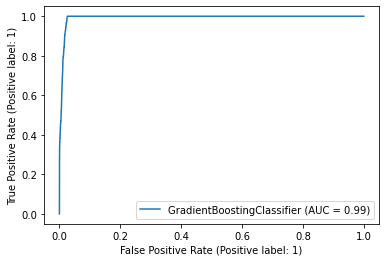

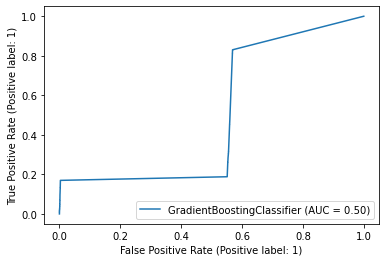

In [77]:
### On the train
RocCurveDisplay.from_estimator(model_gradient_boosting, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of gradient boosting on the train is equal to {max(roc_auc_train_for_boost)}")

### On the test
RocCurveDisplay.from_estimator(model_gradient_boosting, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of the gradient boosting test is equal to {max(roc_auc_test_for_boost)}")

### Let's try the LinearSVC model (Support Vector Machine)

In [78]:
from sklearn.svm import LinearSVC
roc_auc_train_for_svc = []
roc_auc_test_for_svc = []


linear_svc = LinearSVC(random_state=1)

linear_svc.fit(X_train, y_train)
linear_svc.score(X_test, y_test)

### separately, we create probabilities of belonging to one or another class 0 or 1 for transmission to roc_curve below
predict_proba_for_train = linear_svc._predict_proba_lr(X_train)
predict_proba_for_test = linear_svc._predict_proba_lr(X_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_proba_for_train[:, 1]) 
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_proba_for_test[:, 1]) 

### On the train
roc_auc_train_for_svc.append(round(auc(fpr_train, tpr_train), 3))

### On the test
roc_auc_test_for_svc.append(round(auc(fpr_test, tpr_test), 3))

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.p

In [79]:
### On the train
print(f"The ROC-AUC of LinearSVC (support vector machine) on the train is equal to {max(roc_auc_train_for_svc)}")

### On the test
print(f"ROC-AUC for LinearSVC (Support vector machine) on the test {max(roc_auc_test_for_svc)}")

The ROC-AUC of LinearSVC (support vector machine) on the train is equal to 0.983
ROC-AUC for LinearSVC (Support vector machine) on the test 0.014


### Saving the RandomForestRegressor model

In [80]:
import pickle
from sklearn.ensemble import RandomForestClassifier

### Your code is here

model_random_forest = RandomForestClassifier(n_estimators=10,
                                   max_depth=1,
                                   random_state=1)
model_random_forest.fit(X_train, y_train)

filename = 'sklearn_model_random_forest_classifier.pkl'
pickle.dump(model_random_forest, open(filename, 'wb'))

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


The ROC-AUC of a random forest on the train is equal to 0.988
The ROC-AUC of a random forest on the test is equal to 0.738


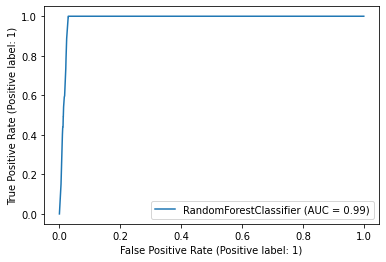

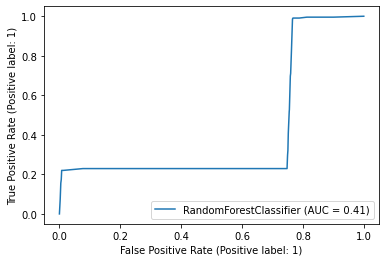

In [81]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

roc_auc_train_for_forest_1=[]
roc_auc_test_for_forest_1=[]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model_random_forest.predict_proba(X_train)[:, 1]) 
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_random_forest.predict_proba(X_test)[:, 1]) 

### On the train
roc_auc_train_for_forest_1.append(round(auc(fpr_train, tpr_train), 3))

### On the test
roc_auc_test_for_forest_1.append(round(auc(fpr_test, tpr_test), 3))
RocCurveDisplay.from_estimator(model_random_forest, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of a random forest on the train is equal to {max(roc_auc_train_for_forest)}")

### На тесте
RocCurveDisplay.from_estimator(model_random_forest, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of a random forest on the test is equal to {max(roc_auc_test_for_forest)}")

In [82]:
filename = 'sklearn_model_random_forest_classifier.pkl'
pickle.dump(model_random_forest, open(filename, 'wb'))

In [83]:
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.predict(X)
model_random_forest.predict(X) # predictions
model_random_forest.predict_proba(X)  # the probability of belonging to a particular class is 0 or 1

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[0.97221893, 0.02778107],
       [0.97221893, 0.02778107],
       [0.97273412, 0.02726588],
       ...,
       [0.9918874 , 0.0081126 ],
       [0.9918874 , 0.0081126 ],
       [0.9918874 , 0.0081126 ]])

### Saving the Gradient Boosting Classifier model

In [84]:
import pickle
from sklearn.ensemble import GradientBoostingClassifier


model_gradient_boosting = GradientBoostingClassifier(n_estimators=15,
                                   max_depth=3,
                                   random_state=1)
model_gradient_boosting.fit(X_train, y_train)

filename = 'sklearn_model_gradient_boosting_classifier.pkl' # creating a name for the file with the model
pickle.dump(model_gradient_boosting, open(filename, 'wb'))

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [85]:
loaded_model = pickle.load(open(filename, 'rb'))  # opening the dump with our model

loaded_model.predict(X) # predictions
loaded_model.predict_proba(X)  # probability of belonging to one or another class 0 or 1

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[7.72583026e-01, 2.27416974e-01],
       [7.72583026e-01, 2.27416974e-01],
       [7.00494245e-01, 2.99505755e-01],
       ...,
       [9.99424580e-01, 5.75420005e-04],
       [9.99300486e-01, 6.99513763e-04],
       [9.99300486e-01, 6.99513763e-04]])

In [86]:
roc_auc_train_for_boost_1 = []
roc_auc_test_for_boost_1 = []

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model_gradient_boosting.predict_proba(X_train)[:, 1]) 
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, model_gradient_boosting.predict_proba(X_test)[:, 1]) 

### On the train
roc_auc_train_for_boost_1.append(round(auc(fpr_train, tpr_train), 3))

### On the test
roc_auc_train_for_boost_1.append(round(auc(fpr_test, tpr_test), 3))

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


The ROC-AUC of gradient boosting on the train is equal to 0.993
The ROC-AUC of the gradient boosting test is equal to 0.502


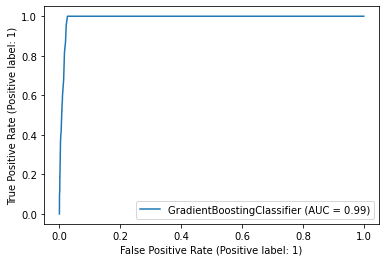

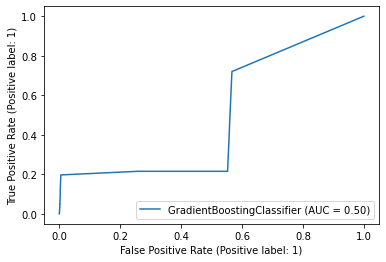

In [87]:
### On the train
RocCurveDisplay.from_estimator(model_gradient_boosting, X_train, y_train) 
print(f"The ROC-AUC of gradient boosting on the train is equal to {max(roc_auc_train_for_boost)}")

### On the test
RocCurveDisplay.from_estimator(model_gradient_boosting, X_test, y_test) 
print(f"The ROC-AUC of the gradient boosting test is equal to {max(roc_auc_test_for_boost)}")

### Saving the Cart Boost model

In [88]:
from catboost import CatBoostClassifier

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

cboost = CatBoostClassifier(max_depth=15,
                            n_estimators=1,random_state=1,
                            verbose=0)


cboost.fit(X_train, y_train)

In [89]:
cboost .save_model('catboost_model',
                           format="cbm")

from_file = CatBoostClassifier()  

from_file.load_model("catboost_model")

from_file.predict(X_train)
from_file.predict_proba(X)  # probability of belonging to one or another class 0 or 1

array([[0.72872868, 0.27127132],
       [0.72872868, 0.27127132],
       [0.68599742, 0.31400258],
       ...,
       [0.70267284, 0.29732716],
       [0.70267284, 0.29732716],
       [0.70267284, 0.29732716]])

The ROC-AUC of CatBoost on the train is equal to 0.866
The ROC-AUC of CatBoost on the test is equal to 0.706


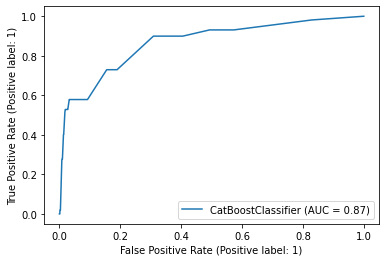

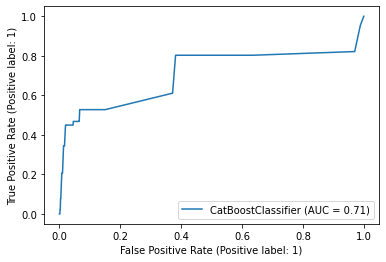

In [90]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

fpr_train_cboost, tpr_train_cboost, thresholds_train_cboost = roc_curve(y_train, cboost.predict_proba(X_train)[:, 1]) 
fpr_test_cboost, tpr_test_cboost, thresholds_test_cboost = roc_curve(y_test, cboost.predict_proba(X_test)[:, 1]) 

RocCurveDisplay.from_estimator(cboost, X_train, y_train) # draw a graph for train
print(f"The ROC-AUC of CatBoost on the train is equal to {round(auc(fpr_train_cboost, tpr_train_cboost),3)}")

RocCurveDisplay.from_estimator(cboost, X_test, y_test) # draw a graph for the test
print(f"The ROC-AUC of CatBoost on the test is equal to {round(auc(fpr_test_cboost, tpr_test_cboost), 3)}")

## Conclusions
1. The best metric is hitrate@5 for the CatBoot model and it is 0.450
2. This solution does not process the text of posts (TF-IDF). The text of the posts will be processed in the following solution with the use of deep learning methods